In [14]:
import pandas as pd
import sqlite3 as sql3

import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from scipy.spatial.distance import cosine

import warnings
warnings.filterwarnings("ignore")

<ipython-input-14-34845c2c9a13>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Для начала подготовим данные в общем виде, которые можно подавать как ариме, так и бустингу. Для этого заджойним данные с
чарта и сессий по session_id. Уберем дубликаты договоров и отсортируем по времени.

In [15]:
def filter_deal_id(data: pd.DataFrame):
    ids = set()
    for i, d_id in enumerate(data["deal_id"]):
        if d_id not in ids:
            ids.add(i)

    data = data.iloc[list(ids)]
    return data


def read_data():
    con = sql3.connect("../data/trade_info.sqlite3")
    data = pd.read_sql(""
                       "SELECT s.id, s.date, c.time, deal_id, c.price "
                       "FROM Trading_session s "
                       "INNER JOIN Chart_data c ON s.id = c.session_id "
                       "WHERE trading_type='monthly' "
                       "ORDER BY date, time",
                       con)

    data = filter_deal_id(data)
    data.price += 10
    con.close()
    return data

data = read_data()

Теперь хотел бы посмотреть на график цен. В датасете цена дана в нормализованном виде. Будем полагать, что
нормализация работала в виде actual_price - initial_price, где initial_price -- это цена самых-самых
первых торгов. Пусть она будет равна 10.

Теперь перейдем к графикам.

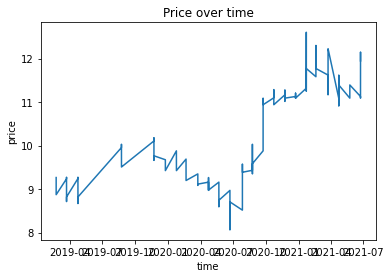

In [16]:
plt.plot(pd.to_datetime(data.date + " " + data.time), data["price"])
plt.title("Price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()


Давайте примени ариму. По-хорошему надо посмотреть, обладают ли данные авто-корреляцией.

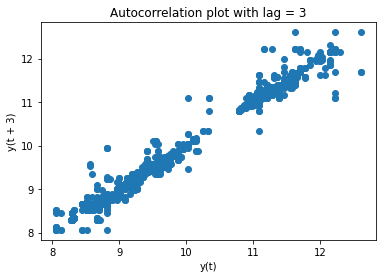

In [17]:
plt.figure()
lag_plot(data['price'], lag=3)
plt.title('Autocorrelation plot with lag = 3')
plt.show()

Кажется, да, есть смысл использовать ариму. Подберем параметры.

In [18]:
train_data, test_data = data[0:int(len(data) * 0.7)], data[int(len(data) * 0.7):]
training_data = train_data['price'].values
test_data = test_data['price'].values
history = [x for x in training_data]

In [19]:
model_autoARIMA = auto_arima(history, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5609.126, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5627.003, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5629.698, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5611.113, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5637.614, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5631.653, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5632.148, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5634.130, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5633.651, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5633.629, Time=1.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5639.586, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5631.678, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5628.977, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5633.632, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0

In [20]:
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

In [21]:
def calc_metrics(test_data, model_predictions):
    MSE_error = mean_squared_error(test_data, model_predictions)
    MAE_error = mean_absolute_error(test_data, model_predictions)
    COS_dist = cosine(test_data, model_predictions)
    print('Testing MSE is {}'.format(MSE_error))
    print('Testing MAE is {}'.format(MAE_error))
    print('Testing cosine dist is {}'.format(COS_dist))

In [22]:
calc_metrics(test_data, model_predictions)

Testing MSE is 0.010150563370785667
Testing MAE is 0.031237222320572525
Testing cosine dist is 4.0189928337430736e-05


In [23]:
def draw_preds(target, preds):
    x = np.arange(len(preds))
    plt.plot(x, preds, color='blue', marker='o', linestyle='dashed', label='Predicted Price')
    plt.plot(x, target, color='red', label='Actual Price')
    plt.title('Prices prediction')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

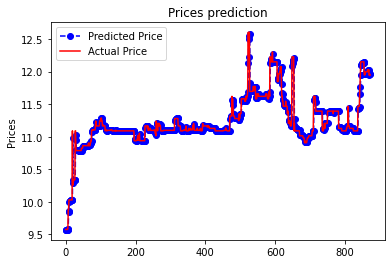

In [24]:
draw_preds(test_data, model_predictions)

Если предсказывать только следующую цену, то результаты получаются хорошими. Попробуем предсказать больше точек.

In [25]:
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

model = ARIMA(history, order=(1, 1, 1))
model_fit = model.fit(disp=0)

output = model_fit.forecast(N_test_observations)

model_predictions.extend(output[0])
history.extend(test_data)

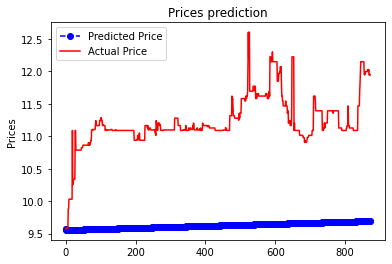

Testing MSE is 2.7197473935164047
Testing MAE is 1.6057395130982375
Testing cosine dist is 0.0005507138769137443


In [26]:
draw_preds(test_data, model_predictions)
calc_metrics(test_data, model_predictions)

Да, здесь уже конечно все не очень. Возможно стоит давать предсказания именно для каждой минуты сессии.
Однако тренд на повышение цены модель уловила.
